In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack 2.0 - Tracking multiple particles with a U-net

This tutorial demonstrates how to track multiple particles using a U-net with DeepTrack 2.0.

The U-net receives as input an image that may or may not contain particles and outputs an image whose pixels represent the probability that there is a particle nearby. Specifically, each pixel has a value between 0 (high confidence that there is no particle close by) and 1 (high confidence that there is a nearby particle).

This tutorial should be perused after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
import deeptrack as dt

import numpy as np
import matplotlib.pyplot as plt

imsize = 64 

## 2. Define the particle

For this example, we consider point particles (point light scatterers). A point particle is an instance of the class `PointParticle`, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [38]:
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
            return np.ones((round(width), round(height), 1))
        
commons = dt.DummyFeature(
    image_size=imsize,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

        
particles = {
    "dumbbell":dt.Sphere(radius=1e-6, position=commons.position - (9, 0)) &  dt.Sphere(radius=1e-6, position=commons.position + (9, 0)),
    "large_sphere": dt.Sphere(radius=1e-6, position=commons.position),
    "small_sphere": dt.Sphere(radius=0.5e-6, position=commons.position),
    "large_ellipse": dt.Ellipse(radius=(1e-6, 2e-6), position=commons.position),
    "small_ellipse": dt.Ellipse(radius=(0.75e-6, 1e-6), position=commons.position),
#     "random_ellipse": dt.Ellipse(radius=0.5e-6 + np.random.rand(2) * 1.5e-6),
    "large_square":Rectangle(width=25, height=25, position=commons.position),
    "small_square":Rectangle(width=15, height=15, position=commons.position),
    "large_rectangle":Rectangle(width=17, height=27, position=commons.position),
    "small_rectangle":Rectangle(width=13, height=18, position=commons.position),
    
#     "random_square":Rectangle(width=lambda: 5 + np.random.rand() * 15, height=lambda width: width, position=commons.position),
#     "rectangle":Rectangle(width=15, height=30, position=commons.position),
#     "random_rectangle":Rectangle(width=lambda: 10 + np.random.rand() * 15, height=lambda: 5 + np.random.rand() * 15, position=commons.position),
    
}

## 3. Define the optical system 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Fluorescence`, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [39]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, imsize, imsize)
)

## 4. Define noises

We introduce two sources of noise (see also [noises_example](../examples/noises_example.ipynb)):
1. A background random offset between 0 and 1.
2. A Poisson noise with a random SNR between 3 and 10.

In [40]:
poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 20,
    background=0.1
)

## 5. Define the image features

We want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

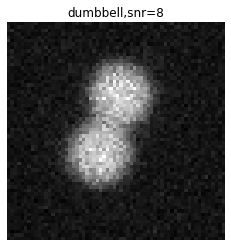

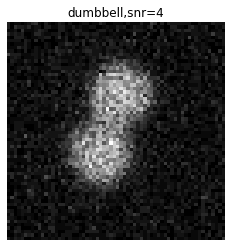

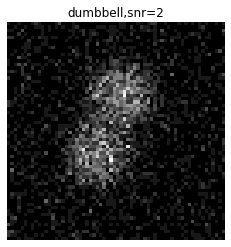

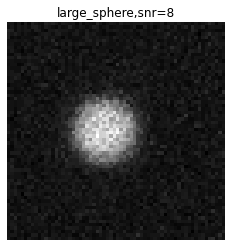

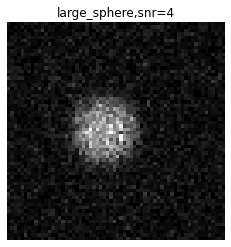

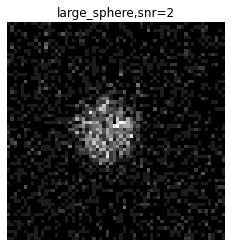

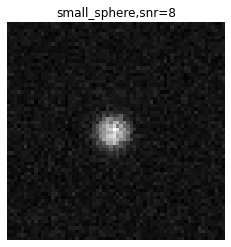

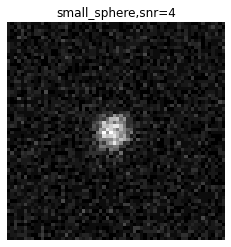

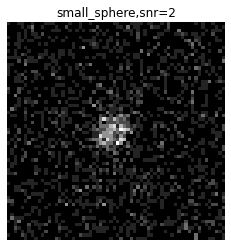

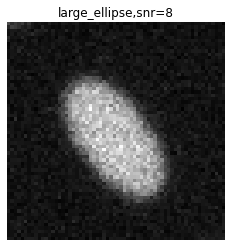

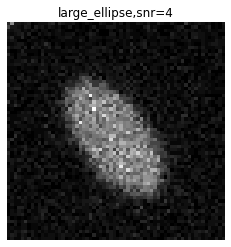

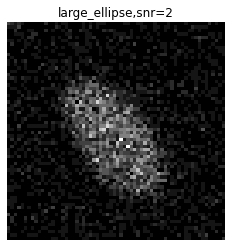

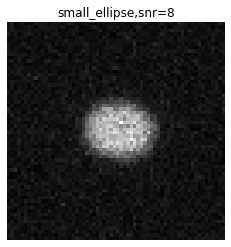

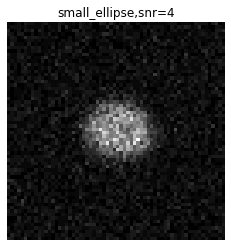

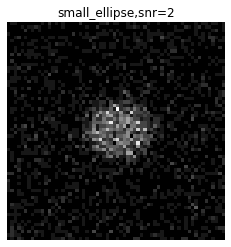

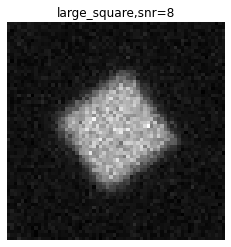

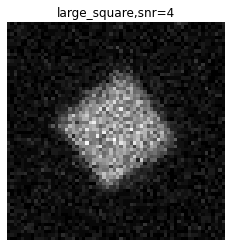

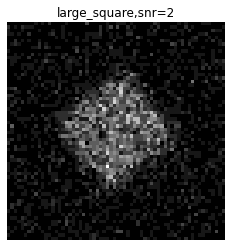

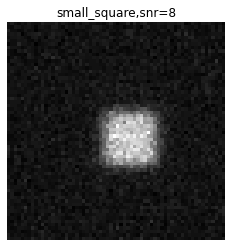

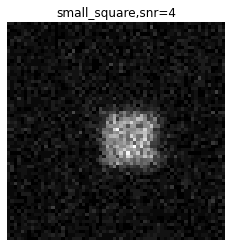

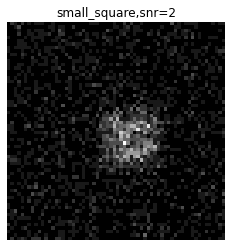

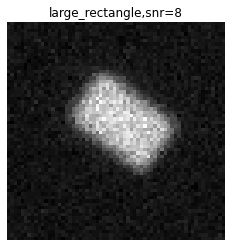

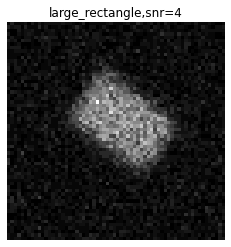

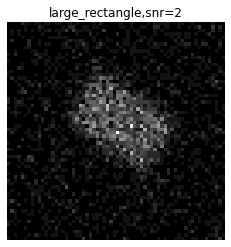

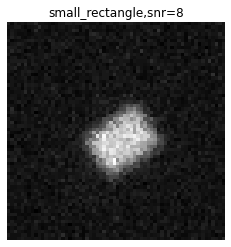

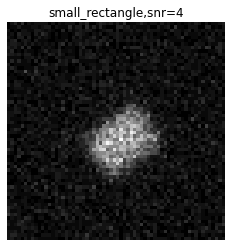

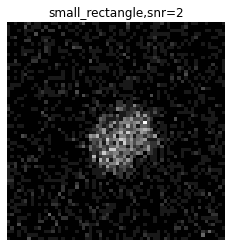

In [51]:
num_particles = lambda: 1
arguments = dt.Arguments(
    noise_level=5
)


pipelines = {}
for key, particle in particles.items():
    
    pipeline = (
        fluorescence_microscope(particle)
        >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
        >> dt.NormalizeMinMax() 
        + 0.1
    ) >> dt.Poisson(snr=arguments.noise_level, background=0.1) >> dt.NormalizeMinMax()
    
    pipeline.bind_arguments(arguments)
    pipeline.update()
    for noise_level in [8, 4, 2]:
        
        f = dt.Bind(pipeline, noise_level=noise_level)
        name = key + f",snr={noise_level}"
        
        example = f()
        
        plt.imshow(example, cmap="gray")
        plt.title(name)
        plt.axis("off")
        plt.show()
        
        
        pipelines[name] = f 
        

## 9. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convolutional model used for image-to-image transformations. We create this model by calling the function `unet` (see also [models_example](../examples/models_example.ipynb)).

Since the desired output is a binary image, we will be using crossentropy as loss. Furthermore, since the target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), we weight the loss such that false negatives are penalized ten times more than the false positives. 

The model can be customized by passing the following arguments:

* `input_shape`: Size of the images to be analyzed. The first two values can be set to `None` to allow arbitrary sizes.

* `conv_layers_dimensions`: Number of convolutions in each convolutional layer during down-
    and upsampling.
    
* `base_conv_layers_dimensions`: Number of convolutions in each convolutional layer at the base
    of the unet, where the image is the most downsampled.

* `output_conv_layers_dimensions`: Number of convolutions in each convolutional layer after the
    upsampling.
    
* `steps_per_pooling`: Number of convolutional layers between each pooling and upsampling
    step.

* `number_of_outputs`: Number of convolutions in output layer.

* `output_activation`: The activation function of the output.

* `loss`: The loss function of the network.

* `optimizer`: The the optimizer used for training.

* `metrics`: Additional metrics to evaulate during training.

## 10. Train the model

The model is trained by calling `.fit()`. This will take a few minutes.

In [42]:
datasets = {}
for name, pipeline in pipelines.items():
    print("Creating dataset for", name)
    dataset = [pipeline.update().resolve() for _ in range(500)]
    dataset_labels = [np.mean(d.get_property("position", get_one=False), axis=0) - imsize/2 for d in dataset]
    datasets[name] = (dataset, dataset_labels)

Creating dataset for dumbbell,snr=8
Creating dataset for dumbbell,snr=4
Creating dataset for dumbbell,snr=2
Creating dataset for large_sphere,snr=8
Creating dataset for large_sphere,snr=4
Creating dataset for large_sphere,snr=2
Creating dataset for small_sphere,snr=8
Creating dataset for small_sphere,snr=4
Creating dataset for small_sphere,snr=2
Creating dataset for large_ellipse,snr=8
Creating dataset for large_ellipse,snr=4
Creating dataset for large_ellipse,snr=2
Creating dataset for small_ellipse,snr=8
Creating dataset for small_ellipse,snr=4
Creating dataset for small_ellipse,snr=2
Creating dataset for large_square,snr=8
Creating dataset for large_square,snr=4
Creating dataset for large_square,snr=2
Creating dataset for small_square,snr=8
Creating dataset for small_square,snr=4
Creating dataset for small_square,snr=2
Creating dataset for large_rectangle,snr=8
Creating dataset for large_rectangle,snr=4
Creating dataset for large_rectangle,snr=2
Creating dataset for small_rectangle,

In [43]:
from deeptrack.extras.radialcenter import radialcenter

metric = lambda x, y: np.sqrt(np.sum(np.square(x - y)))

for name, dataset in datasets.items():
    Y = np.array([np.array(radialcenter(np.array(x), invert_xy=True)) - imsize/2 for x in dataset[0]]) 
    error = [metric(y, l) for y, l in zip(Y, dataset[1])]
    error = np.mean(error)
    print(f"Radialcenter on {name}: \t {error}")

Radialcenter on dumbbell,snr=8: 	 0.43687795003026353
Radialcenter on dumbbell,snr=4: 	 0.8160404735354239
Radialcenter on dumbbell,snr=2: 	 1.3319145154863394
Radialcenter on large_sphere,snr=8: 	 0.2618325025046797
Radialcenter on large_sphere,snr=4: 	 0.7483890444230544
Radialcenter on large_sphere,snr=2: 	 1.3955630120941551
Radialcenter on small_sphere,snr=8: 	 0.2255306291350685
Radialcenter on small_sphere,snr=4: 	 0.7557129672070687
Radialcenter on small_sphere,snr=2: 	 1.5207081357585552
Radialcenter on large_ellipse,snr=8: 	 0.35356246827456866
Radialcenter on large_ellipse,snr=4: 	 0.6784280889118062
Radialcenter on large_ellipse,snr=2: 	 1.1072348901764257
Radialcenter on small_ellipse,snr=8: 	 0.22889348718699842
Radialcenter on small_ellipse,snr=4: 	 0.6664151760823984
Radialcenter on small_ellipse,snr=2: 	 1.273258080898841
Radialcenter on large_square,snr=8: 	 0.3082589344834547
Radialcenter on large_square,snr=4: 	 0.6785459570506521
Radialcenter on large_square,snr=2:

In [44]:
import random

def get_accuracy_matrix(
    training_set_size=1, 
    metric=lambda x, y: np.sqrt(np.sum(np.square(x - y)))
):
    
    models = {}
    
    names = list(datasets.keys())
    
    score = np.zeros((len(names), len(names)))
    
    for name, dataset in datasets.items():
        
        dataset, dataset_labels = dataset
        
        print("Training for", name)
        model = dt.models.AutoTracker(
            input_shape=(imsize, imsize, 1),
        )
        
        training_pipeline = dt.Value(
            value=lambda:random.choice(dataset[:training_set_size])
        )
        
#         generator
        
        model.fit(training_pipeline, batch_size=8, epochs=30)
        
        models[name] = model
        
        for other, other_data in datasets.items():
            
            Y = model.predict(np.array(other_data[0]))
            
            error = [metric(y, l) for y, l in zip(Y, other_data[1])]
            error = error[training_set_size:]
            error = np.mean(error)
            
            
            i = names.index(name)
            j = names.index(other)
            
            score[i, j] = error
        print(score[i, :])
        plt.imshow(score, vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
            
    return score, models
        

Training for dumbbell,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.8632
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.1316
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0545
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0461
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0213
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0366
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0292
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0323
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0221
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0193
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0258
Epoch 12/30
80

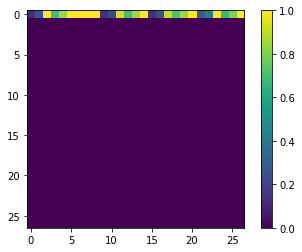

Training for dumbbell,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.0635
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0695
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0512
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0443
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0384
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0229
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0288
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0205
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0399
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0113
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0187
Epoch 12/30
80

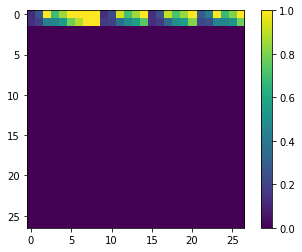

Training for dumbbell,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 3.2412
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0766
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0454
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0338
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0325
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0288
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0337
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0248
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0286
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0217
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0190
Epoch 12/30
80

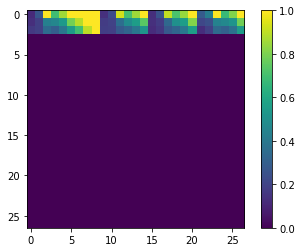

Training for large_sphere,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.3327
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0326
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0183
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0275
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0099
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0218
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0083
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0158
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0078
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0162
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0065
Epoch 12/3

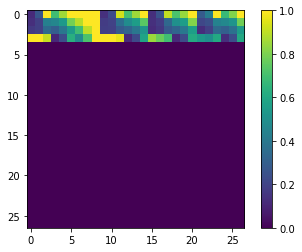

Training for large_sphere,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.9521
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0234
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0270
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0127
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0173
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0123
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0150
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0083
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0108
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0095
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0182
Epoch 12/3

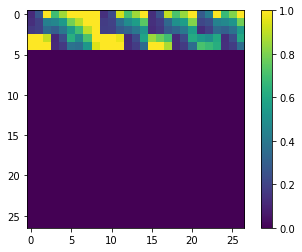

Training for large_sphere,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.1602
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0652
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0276
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0237
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0191
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0229
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0190
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0199
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0196
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0173
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0144
Epoch 12/3

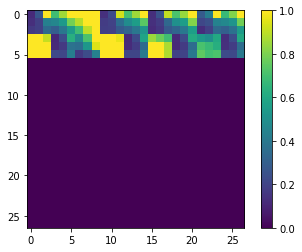

Training for small_sphere,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 1.6696
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0285
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0216
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0144
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0193
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0073
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0178
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0095
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0158
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0117
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0222
Epoch 12/

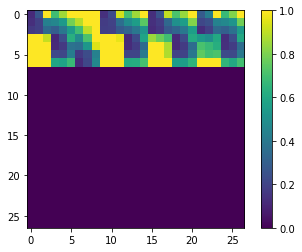

Training for small_sphere,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.0197
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0472
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0218
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0208
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0182
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0151
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0101
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0125
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0119
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0159
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0103
Epoch 12/3

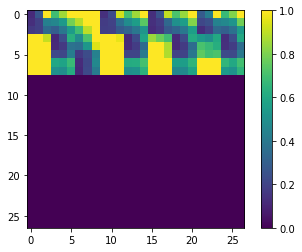

Training for small_sphere,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.0571
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0408
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0297
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0158
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0168
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0146
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0165
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0138
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0149
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0126
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0127
Epoch 12/3

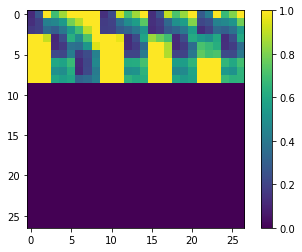

Training for large_ellipse,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.4038
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0414
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0457
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0182
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0268
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0151
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0248
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0108
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0238
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0104
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0146
Epoch 12/

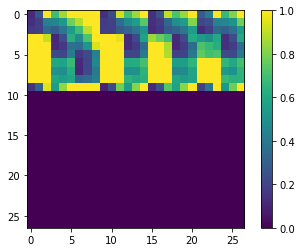

Training for large_ellipse,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.9257
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0949
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0444
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0427
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0357
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0269
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0271
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0244
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0247
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0258
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0147
Epoch 12/

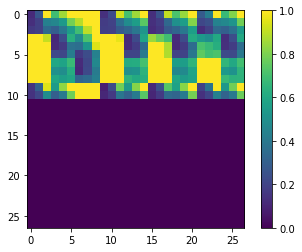

Training for large_ellipse,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.6493
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0717
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0531
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0409
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0305
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0301
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0324
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0284
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0268
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0288
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0214
Epoch 12/

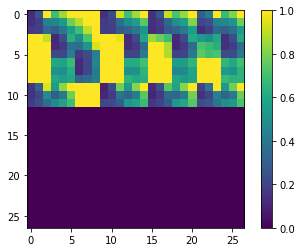

Training for small_ellipse,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.2043
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0413
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0147
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0283
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0139
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0328
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0070
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0187
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0064
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0165
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0068
Epoch 12/

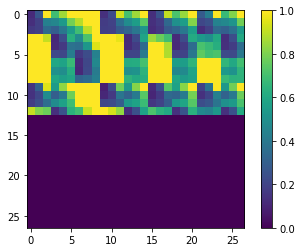

Training for small_ellipse,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 1.8304
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0354
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0285
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0208
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0261
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0155
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0195
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0114
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0125
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0095
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0239
Epoch 12

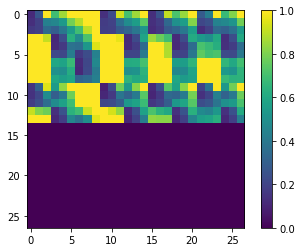

Training for small_ellipse,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.5486
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0607
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0300
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0260
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0178
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0184
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0162
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0191
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0155
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0167
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0148
Epoch 12/

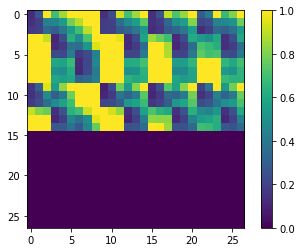

Training for large_square,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.8222
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0283
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0389
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0189
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0272
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0127
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0134: 0s - loss: 0
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0149
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0111: 0s - loss: 0.
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0090
Epoch 11/30
800/800 [==============================] - 9s 11ms/s

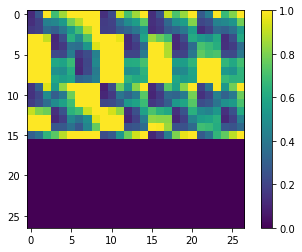

Training for large_square,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 2.1219
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0321
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0272
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0262
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0164
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0219
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0131
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0245
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0121
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0131
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0091
Epoch 12/

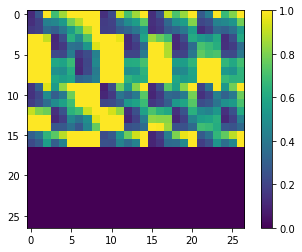

Training for large_square,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.9764
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0399
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0296
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0232
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0196
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0153
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0206
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0152
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0121
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0114
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0160
Epoch 12/3

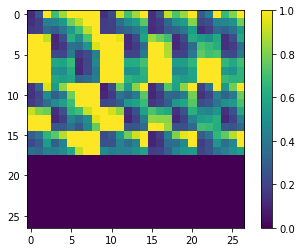

Training for small_square,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.5762
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0189
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0198
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0141
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0168
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0160
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0121
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0148
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0151
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0094
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0104
Epoch 12/3

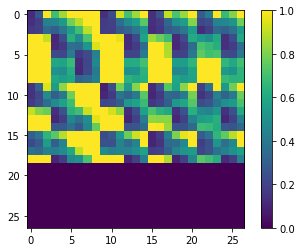

Training for small_square,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 1.8456
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0378
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0246
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0172
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0233
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0115
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0175
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0150
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0093
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0122
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0098
Epoch 12/3

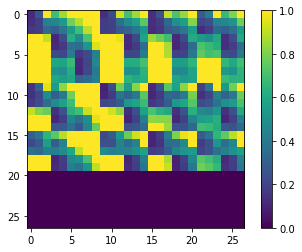

Training for small_square,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.2528
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0279
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0259
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0191
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0174
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0144
Epoch 7/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0160
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0152
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0187
Epoch 10/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0129
Epoch 11/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0186
Epoc

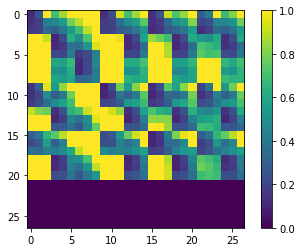

Training for large_rectangle,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.1807
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0377
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0502
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0260
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0411
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0212
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0237
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0189
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0117
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0213
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0121
Epoch 1

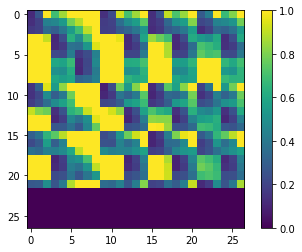

Training for large_rectangle,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.1888
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0352
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0320
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0260
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0298
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0186
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0179
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0204
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0192
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0107
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0123
Epoch 1

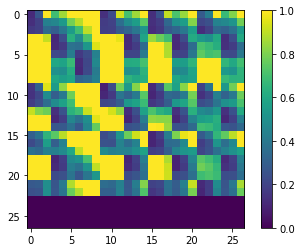

Training for large_rectangle,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.4786
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0646
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0383
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0341
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0329
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0255
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0223
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0307
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0203
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0193
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0183
Epoch 1

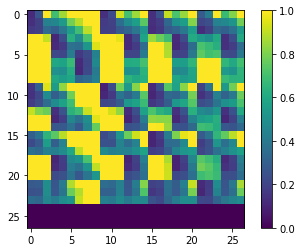

Training for small_rectangle,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 1.7932 0s - loss: 
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0507
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0357
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0266
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0203
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0270
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0137
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0203
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0110
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0124
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 

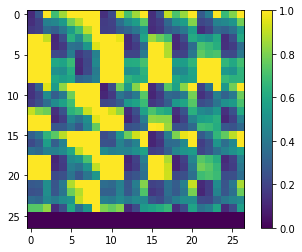

Training for small_rectangle,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 10ms/step - loss: 2.8033
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0623
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0489
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0243
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0323
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0173
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0296
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0146
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0177
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0215
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0306
Epoch 1

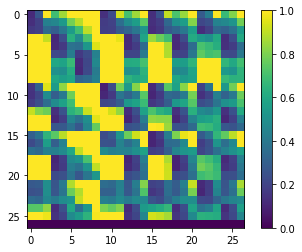

Training for small_rectangle,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 1.8569
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0350
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0240
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0245
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0193
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0203
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0193
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0191
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0178
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0156
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0163
Epoch 

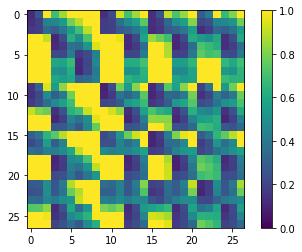

Training for dumbbell,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.2126
Epoch 2/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0741
Epoch 3/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0427
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0375
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0267
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0323
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0310
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0382
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0213
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0225
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0165
Epoch 12/30
80

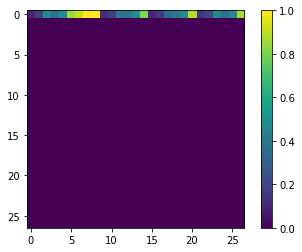

Training for dumbbell,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.6023
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.1167
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0758
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0487
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0341
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0364
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0254
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0224
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0282
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0203
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0158
Epoch 12/30
80

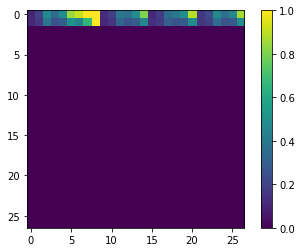

Training for dumbbell,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 2.5041
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.1110
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0979
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0526
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0577
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0410
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0361
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0417
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0311
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0309
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0384
Epoch 12/30
8

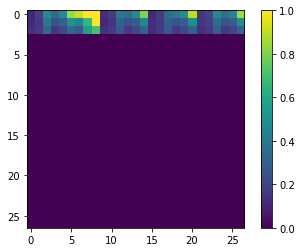

Training for large_sphere,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 11s 12ms/step - loss: 1.7070
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.1031
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0344
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0417
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0172
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0199
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0180
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0216
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0140
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0192
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0153TA: 0s - l

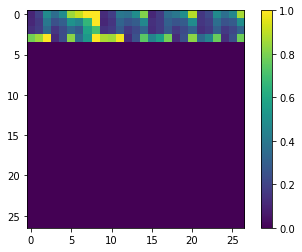

Training for large_sphere,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 1.9530
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0557
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0259
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0291
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0235
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0238
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0218
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0204
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0147
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0160
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0139: 0s - los

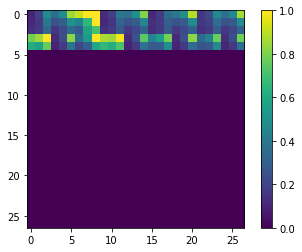

Training for large_sphere,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 3.0112
Epoch 2/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0637
Epoch 3/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0492
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0514
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0453
Epoch 6/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0312
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0270
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0249
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0240
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0245
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0193
Epoch 12

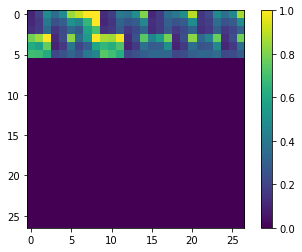

Training for small_sphere,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.0794
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0520
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0550
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0228
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0212
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0254: 0s - loss: 0.0
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0157
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0259
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0178
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0134
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 

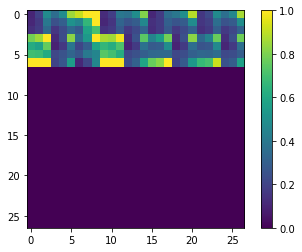

Training for small_sphere,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.0724
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0544
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0371
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0292
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0430
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0199
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0235
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0203
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0369
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0138
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0234
Epoch 12/

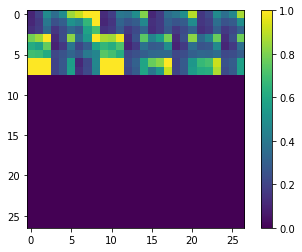

Training for small_sphere,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 10ms/step - loss: 2.5537
Epoch 2/30
800/800 [==============================] - 8s 11ms/step - loss: 0.0621
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0390
Epoch 4/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0422
Epoch 5/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0284
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0277
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0240
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0406
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0205
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0258
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0197
Epoch 12

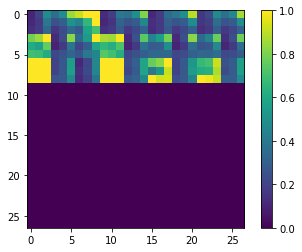

Training for large_ellipse,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.0174
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0955
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0625
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0387
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0550
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0176
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0342
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0413
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0146: 0s - loss: 0.
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0202: 0s - loss:
Epoch 11/30
800/800 [==============================] - 9s 12ms/s

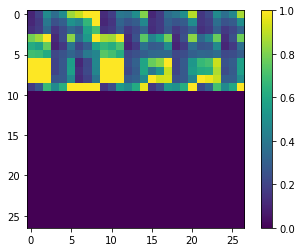

Training for large_ellipse,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.6546
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0875
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0651
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0565
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0462
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0326
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0226
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0284
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0174
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0344
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0191
Epoch 12

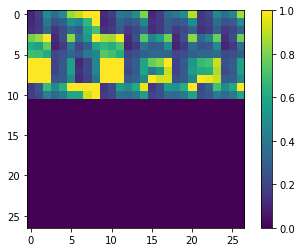

Training for large_ellipse,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 2.4843
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0999
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0741
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0839
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0346
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0599
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0399
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0368
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0381
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0236
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0271
Epoch 12

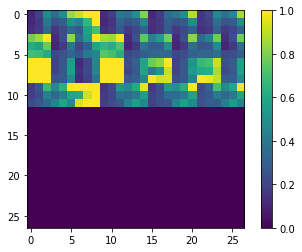

Training for small_ellipse,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.2251
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0496
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0229
Epoch 4/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0391
Epoch 5/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0170
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0323
Epoch 7/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0110
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0184
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0162: 1s -  - ETA: 0s
Epoch 10/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0264
Epoch 11/30
800/800 [==============================] - 10s 12ms/step 

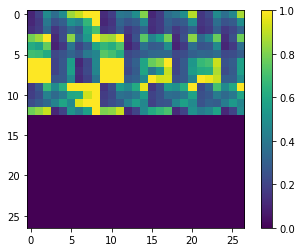

Training for small_ellipse,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.1359
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0635
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0349
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0291
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0185
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0238
Epoch 7/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0208
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0119
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0167
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0143
Epoch 11/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0397
Epoch

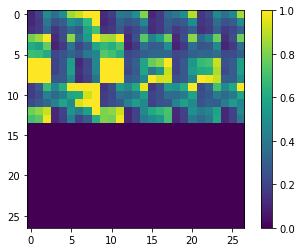

Training for small_ellipse,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 9s 11ms/step - loss: 2.6559
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0669
Epoch 3/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0506
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0614
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0352
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0237
Epoch 7/30
800/800 [==============================] - 8s 11ms/step - loss: 0.0225
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0261
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0252
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0304
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0354
Epoch 12

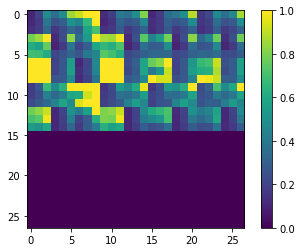

Training for large_square,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 1.6360 0s - loss: 1
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0651
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0355
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0600
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0362
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0207
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0138
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0328
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0153
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0167
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0

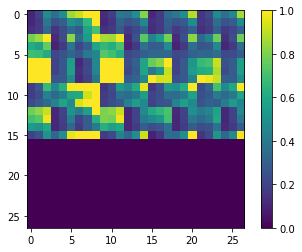

Training for large_square,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 2.2314
Epoch 2/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0536
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0539
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0312
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0538
Epoch 6/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0179
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0247
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0168: 0s - loss: 
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0566
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0122
Epoch 11/30
800/800 [==============================] - 10s 12ms/step - loss: 

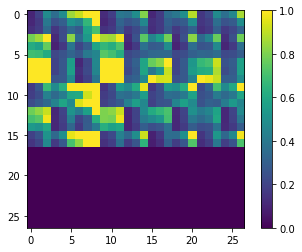

Training for large_square,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 10ms/step - loss: 2.3591
Epoch 2/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0734
Epoch 3/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0592
Epoch 4/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0343
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0350
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0592
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0249
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0435
Epoch 9/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0214
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0276
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0197
Epoch 12/

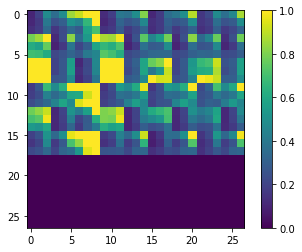

Training for small_square,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.0694
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0360
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0500
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0265
Epoch 5/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0331
Epoch 6/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0235
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0294
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0156
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0214
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0118
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0240
Epoch 12/

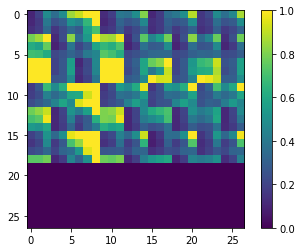

Training for small_square,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.1909
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0720
Epoch 3/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0365
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0522
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0165
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0256
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0160
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0192
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0223
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0230
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0157: 0s - los

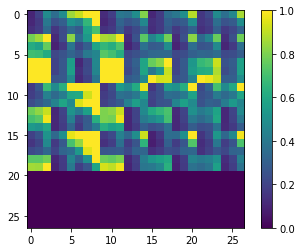

Training for small_square,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.1429
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0546: 0s - loss: 0.05
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0425
Epoch 4/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0436
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0306
Epoch 6/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0260
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0300
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0295
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0272 0s - los
Epoch 10/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0150
Epoch 11/30
800/800 [==============================] - 10s 12m

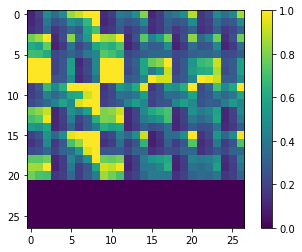

Training for large_rectangle,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 11ms/step - loss: 2.1044
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.1053
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0523
Epoch 4/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0411
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0354
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0214
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0463
Epoch 8/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0313
Epoch 9/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0138
Epoch 10/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0241: 0
Epoch 11/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0125
Epo

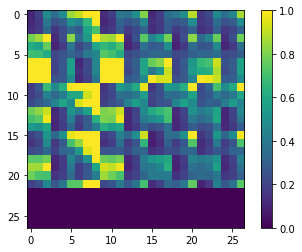

Training for large_rectangle,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.2736 0s - loss:
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0881: - ET
Epoch 3/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0410
Epoch 4/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0594
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0314
Epoch 6/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0321
Epoch 7/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0258 1s - los -
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0342
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0254
Epoch 10/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0206 2s - l
Epoch 11/30
800/800 [==========================

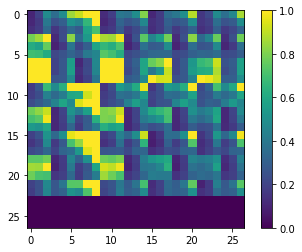

Training for large_rectangle,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.5436
Epoch 2/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0609
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0587
Epoch 4/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0567
Epoch 5/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0450
Epoch 6/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0409
Epoch 7/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0314
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0264
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0456
Epoch 10/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0270
Epoch 11/30
800/800 [==============================] - 10s 12ms/step - loss: 0.02

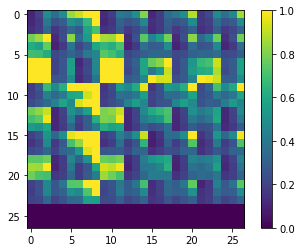

Training for small_rectangle,snr=8
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 10ms/step - loss: 1.9666
Epoch 2/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0625
Epoch 3/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0343
Epoch 4/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0328
Epoch 5/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0162
Epoch 6/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0362
Epoch 7/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0229
Epoch 8/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0204
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0158
Epoch 10/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0307
Epoch 11/30
800/800 [==============================] - 9s 11ms/step - loss: 0.0141
Epoch

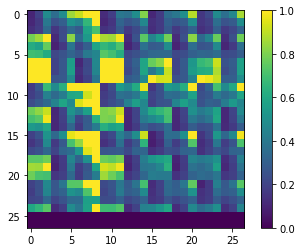

Training for small_rectangle,snr=4
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.2343
Epoch 2/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0591: 0s - loss: 0.05
Epoch 3/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0418
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0252
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0264
Epoch 6/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0207
Epoch 7/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0227
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0162
Epoch 9/30
800/800 [==============================] - 11s 13ms/step - loss: 0.0330
Epoch 10/30
800/800 [==============================] - 11s 14ms/step - loss: 0.0108
Epoch 11/30
800/800 [==============================] - 10s 12ms/ste

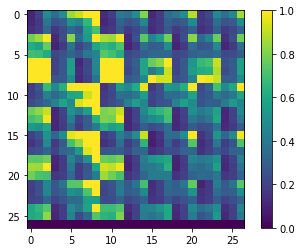

Training for small_rectangle,snr=2
Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 10s 12ms/step - loss: 2.0785 0s - loss: 2.09
Epoch 2/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0787 0s - los
Epoch 3/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0446
Epoch 4/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0477
Epoch 5/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0338
Epoch 6/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0251
Epoch 7/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0299
Epoch 8/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0233
Epoch 9/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0198
Epoch 10/30
800/800 [==============================] - 10s 12ms/step - loss: 0.0357
Epoch 11/30
800/800 [==============================] - 10s 

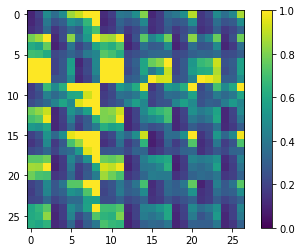

In [45]:
score_1, models_1 = get_accuracy_matrix(1)
score_100, models_100 = get_accuracy_matrix(100)


0.29278165190578714
0.5552852676817531


In [ ]:
score_100

In [ ]:
[0.18317655 0.09671017 0.08064314]
[0.22469646 0.09257973 0.06540189]
[0.25455001 0.10288141 0.07503905]

predictions = model.predict(np.array(dataset))

dataset_labels = np.array([[*d.get_property("position") - imsize/2, d.get_property("rotate")]  for d in dataset])

err = predictions - dataset_labels[:, :2]

plt.scatter(dataset_labels[:, 2], err[:, 0])
plt.show()
plt.scatter(dataset_labels[:, 2], err[:, 1])

In [ ]:
metric = lambda x, y: x - y

error = np.array([metric(y, l) for y, l in zip(Y, dataset[1])])

plt.plot(error[:, 0])
plt.plot(error[:, 1])

In [ ]:
x = image_features.update().resolve()

out = model.predict(x[np.newaxis])[0]

plt.subplot(1, 4, 1)
plt.imshow(x)
plt.subplot(1, 4, 2)
plt.imshow(out[..., 0])
plt.subplot(1, 4, 3)
plt.imshow(out[..., 1])
plt.subplot(1, 4, 4)
plt.imshow(out[..., 2])
plt.show()

In [ ]:
x

## 11. Visualize the model performance

Finally, we evaluate the model performance by showing the model output besides the input image and the target image.

In [ ]:
# generator[0] grabs a single batch from the generator
input_image, target_image = generator[0]

for i in range(input_image.shape[0]):
    
    predicted_image = model.predict(input_image)
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(input_image[i, :, :, 0]), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(predicted_image[i, :, :, 0]), cmap="gray")
    plt.title("Predicted Image")
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(target_image[i, :, :, 0] > 0.5), cmap="gray")
    plt.title("Target image")

    plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_addons
from deeptrack.losses import softmax
K = tf.keras.backend

P = np.ones((2, 32, 32, 3), dtype=np.float32)
P[1] = -1
T = np.array([[1., 0, 0, 0, 1, 0, 0, 0], [-1, 0, 1, 0, -1, 1, 0, 0]], dtype=np.float32)


transform = K.reshape(T[:, :6], (-1, 2, 3))

offset_vector = transform[:, :, 2]
transformation_matrix = transform[:, :2, :2]

# For broadcasting

offset_vector = K.reshape(offset_vector, (-1, 1, 1, 2))
transformation_matrix = K.reshape(transformation_matrix, (-1, 1, 1, 2, 2))

# Transforms and broadcasts the
transformed_origin = tf.linalg.matvec(transformation_matrix, P[:1, ..., :2])

# Transforms all prediced images to match the first image
transformed_field = tensorflow_addons.image.transform(transformed_origin, T, fill_mode="wrap")

error = offset_vector - (P[..., :2] - transformed_field)

error_tot = (
    error
    * softmax(P[:, :, :, 2:3], axis=(1, 2, 3))
    * K.cast_to_floatx(K.shape(error)[1] * K.shape(error)[2])
)
# return error

In [ ]:
transformed_field.numpy()[1, ..., 1]